# Аналитика в Яндекс.Афише

Необходимо помочь маркетологам Яндекс.Афиши оптимизировать маркетинговые затраты.
Имеются данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

    - лог сервера с данными о посещениях сайта Яндекс.Афиши,
    - выгрузка всех заказов за этот период,
    - статистика рекламных расходов.

Изучим следующее:

    - как люди пользуются продуктом,
    - когда они начинают покупать,
    - сколько денег приносит каждый клиент,
    - когда клиент окупается.

## 1. Изучение и подготовка данных к анализу

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')
def df_info(df):
    df.info()
    display(df.describe())
    display(df.head(5))
df_info(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Source Id,Uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [2]:
df_info(orders)
df_info(costs)

#проверим наличие дубликатов
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


0
0
0


In [3]:
#переименуем названия столбцов
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

#переведем данные с датой в тип данных datetime
def convert_to_datetime (df, column):
    df[column] = pd.to_datetime(df[column], format='%Y-%m-%d %H:%M:%S')
convert_to_datetime(visits, 'end_ts')
convert_to_datetime(visits, 'start_ts')
convert_to_datetime(orders, 'buy_ts')
convert_to_datetime(costs, 'dt')

#проверим, что данные переведены в нужный формат и стобцы переименованы
df_info(visits)
df_info(orders)
df_info(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Данные прочитаны, названия столбцов приведены к нижнему регистру и нижнему пробелу, все столбц с датой и временем переведены в формат даты (datetime), наличие дубликатов не обнаружено. 

## 2. Анализ продукта

            uid
visits_day     
2017-06-01  605
2017-06-02  608
2017-06-03  445
2017-06-04  476
2017-06-05  820
2017-06-06  797
2017-06-07  699
2017-06-08  868
2017-06-09  695
2017-06-10  350
uid    907.991758
dtype: float64
device      desktop       touch
count    364.000000  363.000000
mean     659.244505  252.873278
std      284.771685  102.042757
min        1.000000   46.000000
25%      421.750000  173.500000
50%      649.000000  264.000000
75%      877.000000  322.000000
max     2605.000000  777.000000


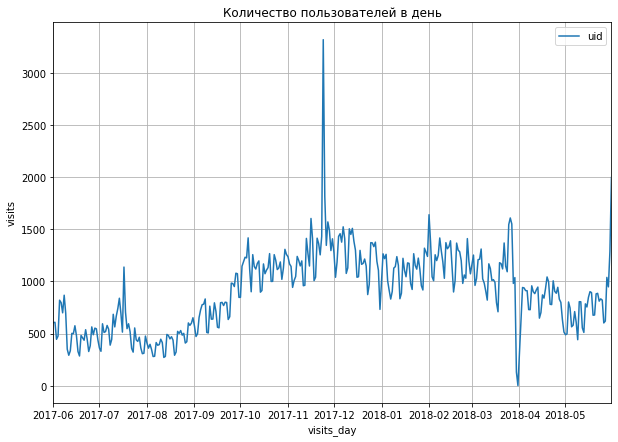

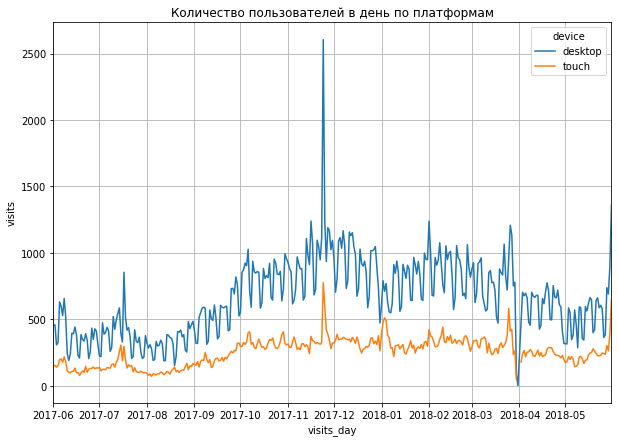

In [4]:
# расчитаем сколько людей пользуется Яндекс.Афишей в день
visits['visits_day'] = visits['start_ts'].dt.date
dau_visits = visits.groupby('visits_day').agg({'uid':'nunique'})
dau_visits.plot(kind = 'line', 
                grid=True, 
                figsize=(10, 7))
plt.title("Количество пользователей в день")
plt.xlabel("visits_day")
plt.ylabel("visits")

# расчитаем сколько людей пользуется Яндекс.Афишей в день по платформам
dau_visits_platform = visits.pivot_table(index='visits_day',
                                      columns='device',
                                      values='uid',
                                      aggfunc='nunique')
dau_visits_platform.plot(kind = 'line', grid=True, figsize=(10, 7))
plt.title("Количество пользователей в день по платформам")
plt.xlabel("visits_day")
plt.ylabel("visits")
print(dau_visits.head(10))
print(dau_visits.mean())
print(dau_visits_platform.describe())

Среднее количество посетителей в день составляет примерно 908 визитов, из них 659 посетители с платформы desktop и 252 человека посетители с платформы touch. По графику видно что было несколько дней скачков, когда посетителей было в разы больше (как с одной, так и с другой платформы) и 2 дня когда количество визитов со всех платформ резко упало до нуля. Резкое падение количества посетителей до нуля скорее всего связано с техническими неполадками. Резкий скачок количества посетителей, возможно связан с ожиданием какой-либо премьеры.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until


              uid
visits_week      
2017-06-01   3562
2017-06-08   2905
2017-06-15   2626
2017-06-22   2801
2017-06-29   2829
2017-07-06   3131
2017-07-13   3925
2017-07-20   2741
2017-07-27   2383
2017-08-03   2256
uid    4232.132075
dtype: float64
device      desktop        touch
count     53.000000    53.000000
mean    4135.754717  1637.264151
std     1540.286623   600.438466
min     1361.000000   586.000000
25%     2932.000000  1110.000000
50%     4162.000000  1805.000000
75%     5403.000000  2138.000000
max     8131.000000  2778.000000


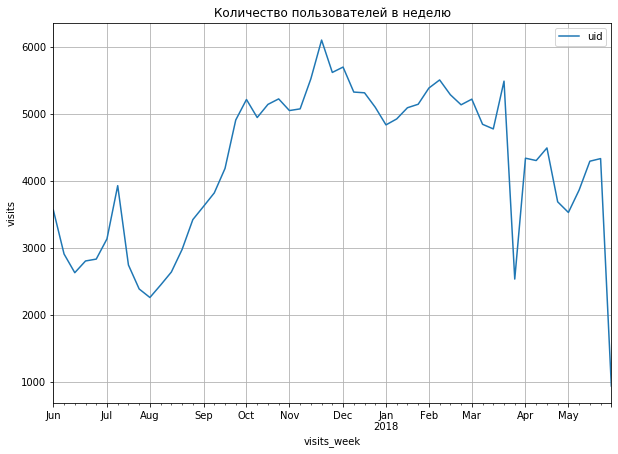

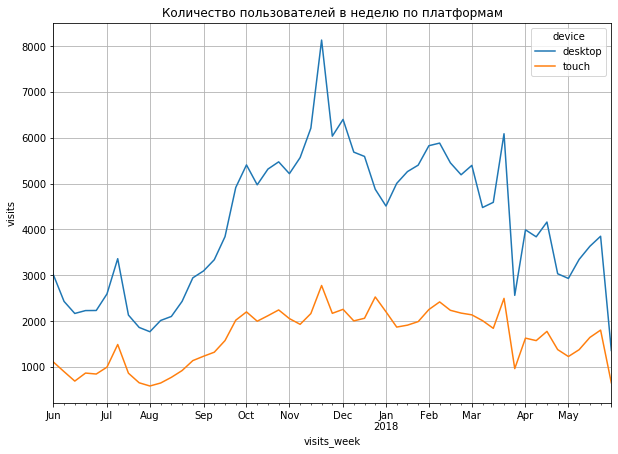

In [5]:
# расчитаем сколько людей пользуется Яндекс.Афишей в неделю
visits['visits_week'] = visits['start_ts'].astype('datetime64[W]')
wau_visits = visits.groupby('visits_week')['start_ts'].agg({'uid':'nunique'})
wau_visits.plot(kind = 'line', 
                grid=True, 
                figsize=(10, 7))
plt.title("Количество пользователей в неделю")
plt.xlabel("visits_week")
plt.ylabel("visits")

# расчитаем сколько людей пользуется Яндекс.Афишей в неделю по платформам
wau_visits_platform = visits.pivot_table(index='visits_week',
                                      columns='device',
                                      values='uid',
                                      aggfunc='nunique')
wau_visits_platform.plot(kind = 'line', grid=True, figsize=(10, 7))
plt.title("Количество пользователей в неделю по платформам")
plt.xlabel("visits_week")
plt.ylabel("visits")

print(wau_visits.head(10))
print(wau_visits.mean())
print(wau_visits_platform.describe())

Среднее количество визитов в неделю составляет 4232 визита. Среднее количесво посещений Яндекс.Афиши с платформы desktop в 2,5 раза больше, чем с платформы touch. Также по графику видно, что основной пик визитов приходится на середину ноября (когда люди начинают готовится к Новому году и выходит большинство премьер), также наблюдает еще один пик в середине марта и снижение числа посетителей в конце марта.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """


device        desktop  touch
visits_month                
2017-06-01       9761   3655
2017-07-01      10145   4223
2017-08-01       8611   3132
2017-09-01      13509   5679
2017-10-01      21286   8856
2017-11-01      24439   8913
2017-12-01      23294   8785
2018-01-01      20350   8741
2018-02-01      20574   8590
2018-03-01      19574   8303
2018-04-01      14844   6387
2018-05-01      14312   6647
uid    18691.916667
dtype: float64
device       desktop        touch
count      12.000000    12.000000
mean    16724.916667  6825.916667
std      5533.916769  2201.062903
min      8611.000000  3132.000000
25%     12668.000000  5315.000000
50%     17209.000000  7475.000000
75%     20752.000000  8752.000000
max     24439.000000  8913.000000


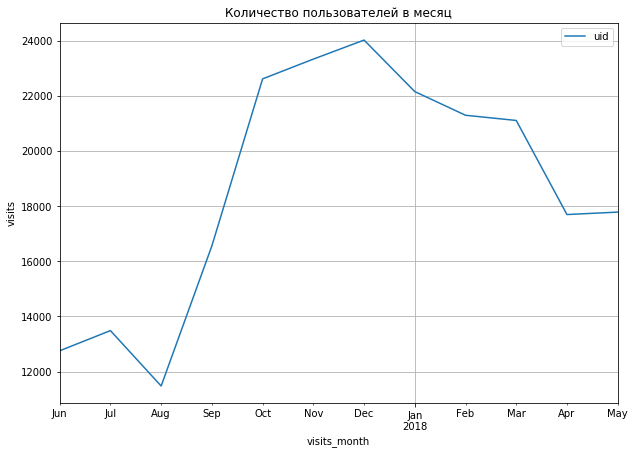

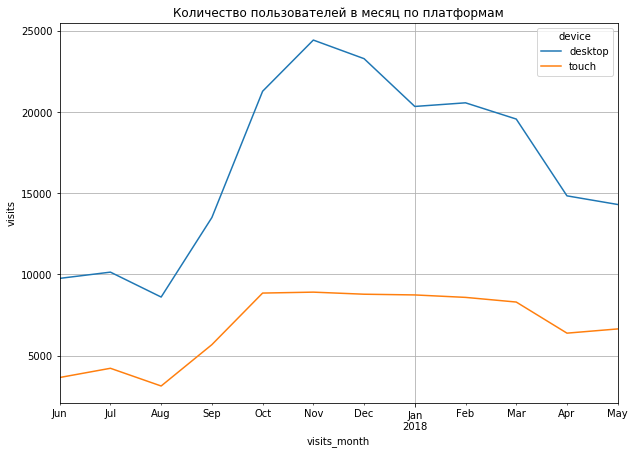

In [6]:
# расчитаем сколько людей пользуется Яндекс.Афишей в месяц
visits['visits_month'] = visits['start_ts'].astype('datetime64[M]')
#возьмем в расчеты данные по визитам кроме июня 2018 года
visits = visits.query('visits_month != "2018-06-01"')
mau_visits = visits.groupby('visits_month')['start_ts'].agg({'uid':'nunique'})
mau_visits.plot(kind = 'line', 
                grid=True, 
                figsize=(10, 7))
plt.title("Количество пользователей в месяц")
plt.xlabel("visits_month")
plt.ylabel("visits")

# расчитаем сколько людей пользуется Яндекс.Афишей в месяц по платформам
mau_visits_platform = visits.pivot_table(index='visits_month',
                                      columns='device',
                                      values='uid',
                                      aggfunc='nunique')
mau_visits_platform.plot(kind = 'line', grid=True, figsize=(10, 7))
plt.title("Количество пользователей в месяц по платформам")
plt.xlabel("visits_month")
plt.ylabel("visits")

print(mau_visits_platform)
print(mau_visits.mean())
print(mau_visits_platform.describe())

Среднее количество посетителей в месяц 18691 человек, из них в около 89% это посетители с платформы desktop и 36% посетители с платформы touch (получается больше 100% так, как одни и те же посетители могут быть и с платформы desktop и с платформы touch). Количество пользователей в летние месяцы сильно снижается, наименьшее количество посетителей с июня по август (время отпусков и летних каникул). Начиная с сентября, число посетителей резко возрастает и держится высоким до января, при этом число посетителей с платформы touch держится примерно на одном уровне с октября по март.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


uid    1.08217
dtype: float64
0    18.0
1    28.0
2     0.0
3    24.0
4     0.0
Name: session_time_min, dtype: float64


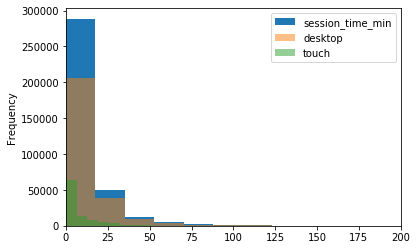

0    1.0
dtype: float64
10.725108143201632
5.0


In [7]:
#расчитаем количество сессий в день на 1 пользователя
session_day_count = visits.groupby('visits_day')['end_ts'].agg({'uid':'count'})
session_day_count_per_one = session_day_count / dau_visits
print(session_day_count_per_one.mean())

#продолжительность одной сессии
visits['session_time_min'] = ((visits['end_ts'] - visits['start_ts']).dt.seconds) / 60
print(visits['session_time_min'].head())
visits['session_time_min'].plot(kind = 'hist', bins=80)
device_session = visits.groupby('device')['session_time_min'].plot(kind='hist', bins=80,alpha=0.5, xlim=(0,200))
plt.legend()
plt.show()

print(visits['session_time_min'].mode()) #узнаем среднюю продолжительность сессии
print(visits['session_time_min'].mean())
print(visits['session_time_min'].median())

Средняя продолжительность одной сессии составляет 10 минут, медианное значение 5 минут и мода (наиболее часто встречающееся значение) 1 минута. Провести одну минуту на сайте можно в случае, если человек завершает покупку переходом на Яндекс.Афишу и оплачивает ее там. Для полноценного выбора мероприятия (проводя время выбора на сайте Яндекс.Афиша) считаю, что среднюю продолжительность одной сесии необходимо считать 10 минут, так как это оптимальное время для просмотра и выбора интересующего события.

,device,end_ts,source_id,start_ts,uid,visits_day,visits_week,visits_month,session_time_min,first_visits_date,first_visits_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,18.0,2017-12-20 17:20:00,2017-12-01,0.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,28.0,2018-02-19 16:53:00,2018-02-01,0.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0.0,2017-07-01 01:54:00,2017-07-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,24.0,2018-03-09 20:05:00,2018-03-01,61.0
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,28.0,2018-03-09 20:05:00,2018-03-01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2018-04-23 21:19:00,10,2018-04-23 21:11:00,12734910664455613822,2018-04-23,2018-04-19,2018-04-01,8.0,2018-04-23 21:11:00,2018-04-01,0.0
359396,desktop,2017-11-08 13:39:00,4,2017-11-08 13:39:00,6761309174945977743,2017-11-08,2017-11-02,2017-11-01,0.0,2017-11-08 13:39:00,2017-11-01,0.0
359397,desktop,2017-07-31 12:31:00,3,2017-07-31 12:13:00,11102751930812818282,2017-07-31,2017-07-27,2017-07-01,18.0,2017-07-31 12:13:00,2017-07-01,0.0
359398,desktop,2018-03-20 15:25:00,4,2018-03-20 15:11:00,272012551460639309,2018-03-20,2018-03-15,2018-03-01,14.0,2018-03-20 15:11:00,2018-03-01,0.0


,first_visits_month,cohort_lifetime,uid
0,2017-06-01,0.0,13259
1,2017-06-01,30.0,1043
2,2017-06-01,61.0,713
3,2017-06-01,92.0,814
4,2017-06-01,122.0,909
...,...,...,...
73,2018-03-01,31.0,861
74,2018-03-01,61.0,557
75,2018-04-01,0.0,15709
76,2018-04-01,30.0,760


0.06516659710392834


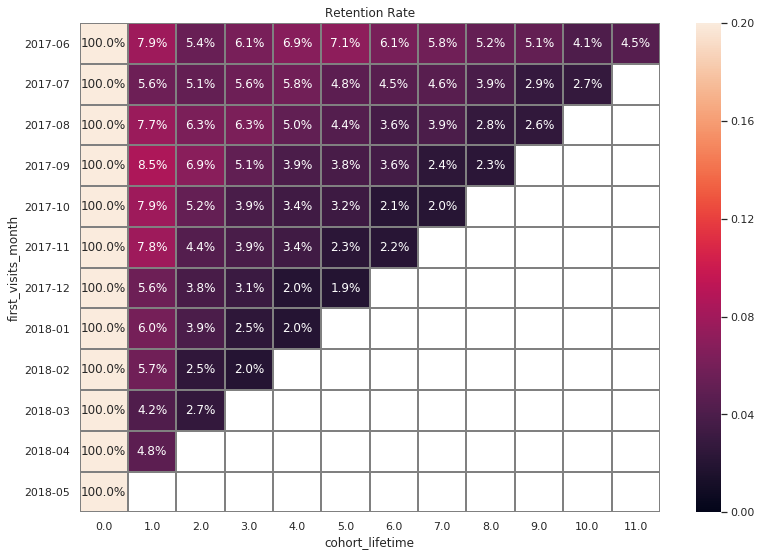

In [8]:
#расчет retention rate (как часто люди возвращаются)
first_visits_date = visits.groupby(['uid'])['start_ts'].min()
first_visits_date.name = 'first_visits_date'
visits = visits.merge(first_visits_date, on = 'uid')

visits['first_visits_month'] = visits['first_visits_date'].astype('datetime64[M]')
visits['visits_month'] = visits['start_ts'].astype('datetime64[M]')
visits['cohort_lifetime'] = (visits['visits_month'] - visits['first_visits_month']) / pd.to_timedelta(1, unit='d')
display(visits)

cohorts = visits.groupby(['first_visits_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
display(cohorts)

initial_visits_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visits_month','uid']]
initial_visits_count = initial_visits_count.rename(columns = {'uid':'cohort_visits'})

cohorts = cohorts.merge(initial_visits_count, on='first_visits_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_visits']
cohorts['cohort_lifetime'] = round(cohorts['cohort_lifetime'] / 30)
cohorts['first_visits_month'] = cohorts['first_visits_month'].dt.strftime('%Y-%m')
retention_pivot = cohorts.pivot_table(index='first_visits_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum'
                                     )
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            vmin = 0, vmax= 0.2)
mean_retention_for_1_cohort = (cohorts[cohorts['cohort_lifetime'] == 1]['retention']).mean()

print(mean_retention_for_1_cohort)


В среднем Retention Rate в первой когорте составляет 6,5 %. Во второй, третьей и последующих когортах Retention Rate убывает быстрее, то есть количество возвращающихся клиентов падает. Таким образом, получается что летние посетители наиболее часто возвращаются на сайт.

In [9]:
#расчет retention rate по платформам
cohorts_platform = visits.pivot_table(index='first_visits_month',
                                      columns='device',
                                      values='uid',
                                      aggfunc='nunique')

cohorts_platform['retention_desktop'] = cohorts_platform['desktop'] / mau_visits_platform['desktop']
cohorts_platform['retention_touch'] = cohorts_platform['touch'] / mau_visits_platform['touch']

print(cohorts_platform)
print(mau_visits_platform)

print(cohorts_platform['retention_desktop'].mean())
print(cohorts_platform['retention_touch'].mean())


device              desktop  touch  retention_desktop  retention_touch
first_visits_month                                                    
2017-06-01            10127   4106           1.037496         1.123393
2017-07-01             9610   4354           0.947265         1.031021
2017-08-01             7635   3015           0.886657         0.962644
2017-09-01            12006   5488           0.888741         0.966367
2017-10-01            18787   8299           0.882599         0.937105
2017-11-01            20439   7862           0.836327         0.882082
2017-12-01            18653   7392           0.800764         0.841434
2018-01-01            15976   7216           0.785061         0.825535
2018-02-01            15700   6967           0.763099         0.811059
2018-03-01            14474   6460           0.739450         0.778032
2018-04-01            10864   5033           0.731878         0.788007
2018-05-01            10252   5153           0.716322         0.775237
device

Retention Rate c платформы touch выше по когортам, чем с платформы desktop, скорее всего это связано с тем, что с платформы touch легче зайти на сайт, так как смартфон "всегда под рукой".

## 3. Анализ продаж

In [10]:
#Рассчитаем через какое время пребывания на сайте пользователь совершает покупку
new_visits = visits.merge(orders, on='uid')
#отфильтруем тблицу, где время покупки входит в интервал начала и окончания сессии
new_visits = new_visits.query('buy_ts <= end_ts and buy_ts >= start_ts')
#рассчитаем время от начала сесии до времени совершения покупки
new_visits['time_to_buy'] = (new_visits['buy_ts'] - new_visits['start_ts']).dt.ceil('1T')
#сгруппируем данные по пользователям, сколько покупок за какое время было совершено
time_to_buy_for_unique_uid = new_visits.groupby('uid')['time_to_buy'].agg({'uid':'nunique', 'time_to_buy': 'sum'})
time_to_buy_for_unique_uid = time_to_buy_for_unique_uid.rename(columns = {'uid':'count_buyers'})

print(time_to_buy_for_unique_uid.sort_values(by='count_buyers', ascending=False))
print(time_to_buy_for_unique_uid.describe())
print(new_visits['time_to_buy'].mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


                      count_buyers     time_to_buy
uid                                               
13888745432979765063            45 1 days 09:58:00
5139615590553126732             39 0 days 20:10:00
11920452646463905188            38 1 days 01:57:00
10116135452198588850            34 0 days 18:47:00
6948781160947906362             33 0 days 18:58:00
...                            ...             ...
6421131338959857573              1 0 days 00:14:00
6420921022680275764              1 0 days 00:00:00
6420696966792439604              1 0 days 00:01:00
6420192775765629462              1 0 days 00:11:00
18446167067214817906             1 0 days 00:04:00

[29794 rows x 2 columns]
       count_buyers             time_to_buy
count  29794.000000                   29794
mean       1.163187  0 days 00:11:51.940659
std        0.963165  0 days 00:33:33.782630
min        1.000000         0 days 00:00:00
25%        1.000000         0 days 00:02:00
50%        1.000000         0 days 00:05:00
75%

В среднем люди совершают покупку через 9 минут с начала старта сесcии.  

                uid
count  45991.000000
mean       1.096193
std        0.339232
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
               uid
count    53.000000
mean    951.226415
std     405.229880
min     319.000000
25%     631.000000
50%     972.000000
75%    1214.000000
max    2120.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  # Remove the CWD from sys.path while we load stuff.


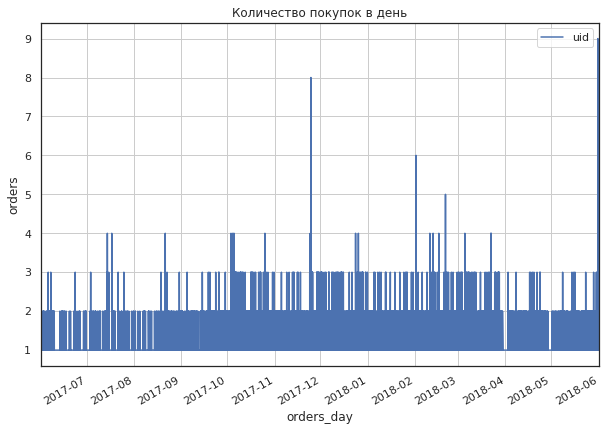

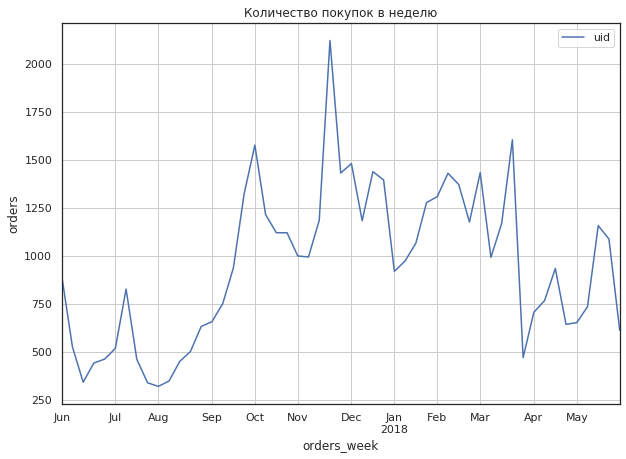

In [11]:
# расчитаем сколько покупок совершено в день, неделю, месяц
orders_day_count = orders.groupby('buy_ts').agg({'uid':'count'})
orders_day_count.plot(kind = 'line', grid=True, figsize=(10, 7))
plt.title("Количество покупок в день")
plt.xlabel("orders_day")
plt.ylabel("orders")
print(orders_day_count.describe())

orders['orders_week'] = orders['buy_ts'].astype('datetime64[W]')
orders_week_count = orders.groupby('orders_week')['buy_ts'].agg({'uid':'count'})
orders_week_count.plot(kind = 'line', grid=True, figsize=(10, 7))
plt.title("Количество покупок в неделю")
plt.xlabel("orders_week")
plt.ylabel("orders")

print(orders_week_count.describe())


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until


               uid
count    12.000000
mean   4201.166667
std    1511.972092
min    1807.000000
25%    3045.500000
50%    4533.500000
75%    5409.250000
max    6218.000000
device        desktop  touch
orders_month                
2017-06-01       1765    454
2017-07-01       1655    539
2017-08-01       1263    360
2017-09-01       2311    688
2017-10-01       4015   1104
2017-11-01       3930   1141
2017-12-01       4185   1267
2018-01-01       3259    986
2018-02-01       3529   1166
2018-03-01       3523   1064
2018-04-01       2345    642
2018-05-01       2943    873
device      desktop        touch
count     12.000000    12.000000
mean    2893.583333   857.000000
std     1001.921831   309.004266
min     1263.000000   360.000000
25%     2174.500000   616.250000
50%     3101.000000   929.500000
75%     3629.250000  1113.250000
max     4185.000000  1267.000000


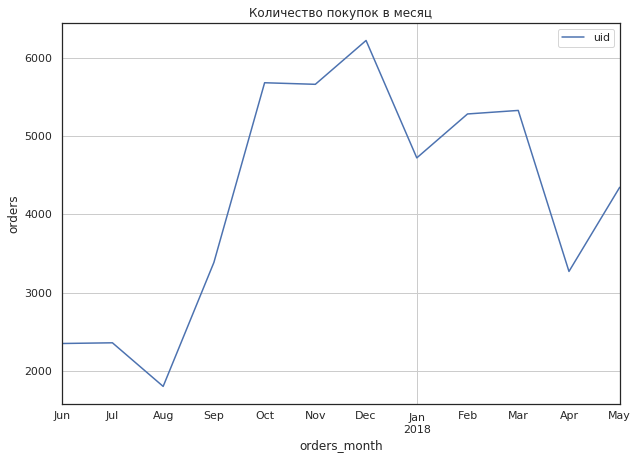

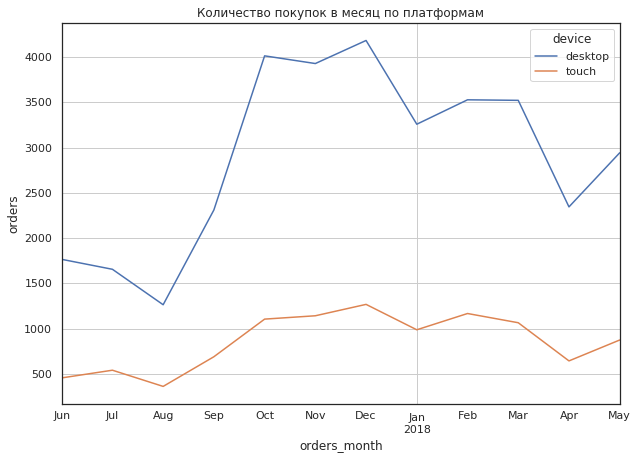

In [12]:
orders['orders_month'] = orders['buy_ts'].astype('datetime64[M]')
orders = orders.query('orders_month != "2018-06-01"')
orders_month_count = orders.groupby('orders_month')['buy_ts'].agg({'uid':'count'})
orders_month_count.plot(kind = 'line', 
                        grid=True, 
                        figsize=(10, 7))
plt.title("Количество покупок в месяц")
plt.xlabel("orders_month")
plt.ylabel("orders")

print(orders_month_count.describe())

orders_by_platform = visits.merge(orders, on='uid')

orders_by_platform_month = orders_by_platform.pivot_table(index='orders_month',
                                                    columns='device',
                                                    values='uid',
                                                    aggfunc='nunique')
print(orders_by_platform_month)
orders_by_platform_month.plot(kind = 'line', grid=True, figsize=(10, 7))
plt.title("Количество покупок в месяц по платформам")
plt.xlabel("orders_month")
plt.ylabel("orders")
print(orders_by_platform_month.describe())

Что касается покупок, то в среднем пользователи совершают одну покупку в день, 951 покупку в неделю и 4201 покупку в месяц. Если, сравнить эти данные с количеством визитов, то получится что в день совершает покупку только 1 из 907 посетителей, в неделю покупку совершают 22% посетителей и в месяц 22,5% посетителей. Среднее количество покупок через desktop выше, чем через touch. Количество покупок через платформу touch составляет 20,1%. 

               revenue
orders_month          
2017-06-01    4.060106
2017-07-01    5.306589
2017-08-01    4.847139
2017-09-01    5.416448
2017-10-01    4.928280
2017-11-01    4.783518
2017-12-01    5.852139
2018-01-01    4.112927
2018-02-01    4.840095
2018-03-01    5.413930
2018-04-01    5.150645
2018-05-01    4.771279
count    50414.000000
mean         4.999678
std         21.818574
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64
device    desktop      touch
count   12.000000  12.000000
mean     8.488062  10.010015
std      2.644008   5.093983
min      5.617276   5.722232
25%      6.922104   6.442263
50%      7.365885   7.994518
75%      9.694481  12.032577
max     14.742187  22.168271


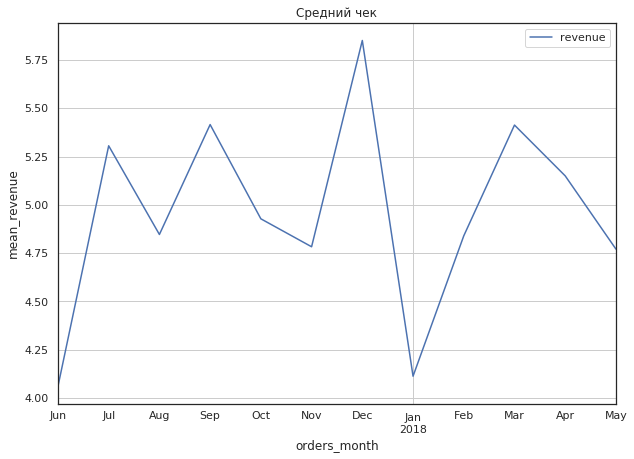

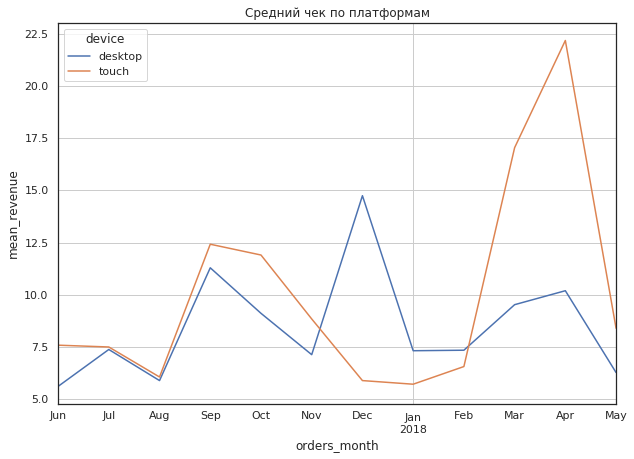

In [13]:
#расчитаем средний чек
mean_chek_month = orders.groupby('orders_month').agg({'revenue':'mean'})
print(mean_chek_month)
mean_chek_month.plot(kind = 'line', 
                        grid=True, 
                        figsize=(10, 7))
plt.title("Средний чек")
plt.xlabel("orders_month")
plt.ylabel("mean_revenue")

print(orders['revenue'].describe())
                                                    
mean_check_by_platform = orders_by_platform.pivot_table(index='orders_month',
                                                            columns='device',
                                                            values='revenue',
                                                            aggfunc='mean')
mean_check_by_platform.plot(kind = 'line', 
                        grid=True, 
                        figsize=(10, 7))
plt.title("Средний чек по платформам")
plt.xlabel("orders_month")
plt.ylabel("mean_revenue")
print(mean_check_by_platform.describe())

Средний чек в месяц равен 4.999647 у.е. Средний чек вырстает в декабре (скорее всего это связано с семейными предновогодними походами на различне мероприятия) и резко падает в январе, когда такие мероприятия становятся уже не инетересны. Что касается среднего чека по платформам, то средний чек с платформы touch вше на 25%, чем средний чек с платформы desctop. В декабре покупку чаще всего совершают через desktop, а с с февраля по май 2018 через платформу touch.

  first_order_month order_month  revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58
  first_order_month  n_buyers order_month  revenue
0        2017-06-01      2023  2017-06-01  9557.49
1        2017-06-01      2023  2017-07-01   981.82
2        2017-06-01      2023  2017-08-01   885.34
3        2017-06-01      2023  2017-09-01  1931.30
4        2017-06-01      2023  2017-10-01  2068.58
age                      0        1        2        3        4        5   \
first_order_month                                                          
2017-06-01         4.724414  5.20974  5.64738  6.60205  7.62458  8.36008   
2017-07-01         6.010218  6.34543  6.96896  7.32794  7.50473  7.66077   
2017-08-01         5.276518  5.74851  6.20699  6.59827  7.09232  7.37586   
2017-09-01         5.644529  6.76212  7.28305  11.2588  11.6594  12.

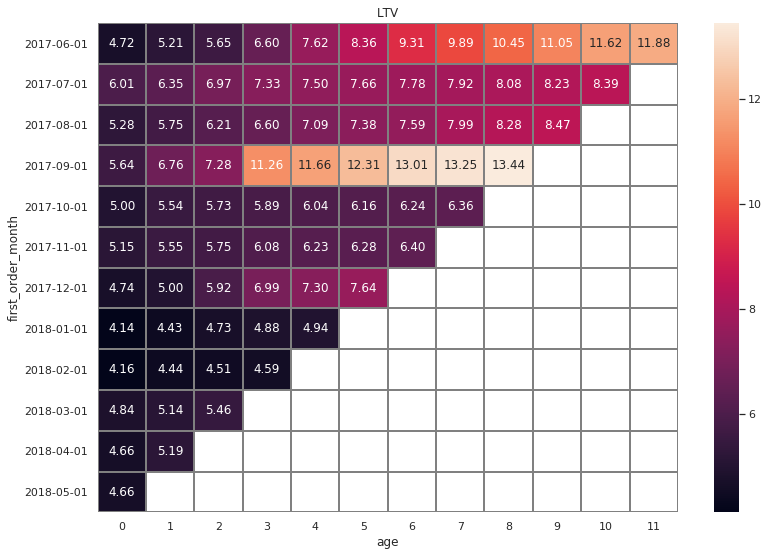

In [14]:
#сгруппируем когорты покупателей по месяцам
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

#посчитаем количество новых покупателей за каждый месяц
new_buyers_count = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
new_buyers_count.columns = ['first_order_month', 'n_buyers']

orders_new = pd.merge(orders,first_orders, on='uid')

cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
print(cohorts.head())

report = pd.merge(new_buyers_count, cohorts, on='first_order_month')
print(report.head())

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']

report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m-%d')    
pivot_report = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').cumsum(axis=1)

print(pivot_report.fillna(''))

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(pivot_report, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray')
print(report['ltv'].mean())

Наибольшую прибыль приносят клиенты, подписавшиеся в июне и сентябре. В среднем один покупатель приносит 12% дополнительной прибыли.

## 4. Аналитика маркетинга

        month  source_id  costs_x
0  2017-06-01          1  1125.61
1  2017-06-01          2  2427.38
2  2017-06-01          3  7731.65
3  2017-06-01          4  3514.80
4  2017-06-01          5  2616.12
..        ...        ...      ...
79 2018-05-01          3  9411.42
80 2018-05-01          4  4214.21
81 2018-05-01          5  3669.56
82 2018-05-01          9   362.17
83 2018-05-01         10   409.86

[84 rows x 3 columns]
329131.61999999994
252053.77999999997
               costs
source_id           
1           20833.27
2           42806.04
3          141321.63
4           61073.60
5           51757.10
9            5517.49
10           5822.49


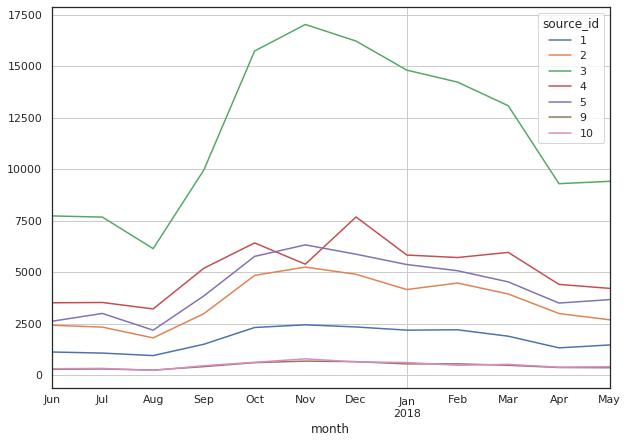

In [15]:
# считаем расходы за месяц 
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_month = costs.groupby(['month','source_id'])[['costs']].sum()
costs_month = costs_month.add_suffix('_x').reset_index()
print(costs_month)

costs.pivot_table(index='month', 
                        columns='source_id', 
                        values='costs', 
                        aggfunc='sum').plot(kind='line', grid=True, figsize=(10, 7))

print(costs_month['costs_x'].sum()) #всего расходов
print(orders['revenue'].sum()) #выручка
costs_sours_id = costs.groupby('source_id').sum()
print(costs_sours_id)

Всего расходы на рекламу составили 329131.61999999994 у.е., а доходы 252057.19999999998 у.е., убыток составил примерно - 77074 у.е. 
Наиболее дорогой канал привлечения клиентов, источник №3. Расходы на все источники, возрастают с сентября по ноябрь.

source_id                1         2         3         4         5         9   \
first_order_month                                                               
2017-06            0.556406  1.199891  3.821873  1.737420  1.293188  0.140989   
2017-07            0.557920  1.213266  3.990832  1.835533  1.559095  0.157327   
2017-08            0.694752  1.321934  4.484336  2.348438  1.595095  0.181701   
2017-09            0.581949  1.156784  3.860345  2.011724  1.491337  0.161031   
2017-10            0.533583  1.116359  3.626092  1.479456  1.328894  0.140417   
2017-11            0.599157  1.285881  4.171855  1.320466  1.549949  0.167405   
2017-12            0.534155  1.117454  3.700552  1.752332  1.339840  0.150121   
2018-01            0.648141  1.232653  4.390388  1.729259  1.592505  0.162218   
2018-02            0.603802  1.225511  3.897168  1.564492  1.389019  0.151055   
2018-03            0.535831  1.116088  3.702477  1.687481  1.282089  0.135944   
2018-04            0.583256 

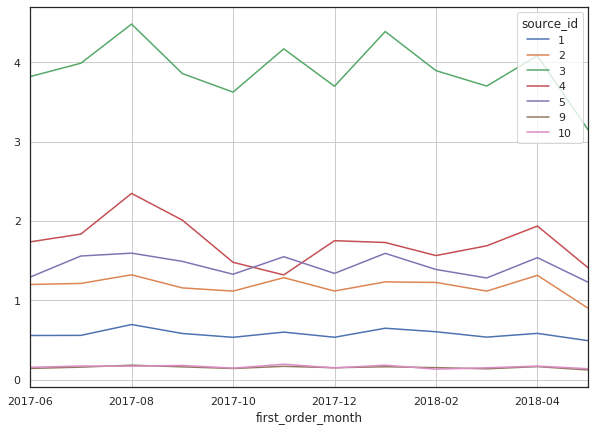

In [16]:
#Сколько стоило привлечение одного покупателя из каждого источника?
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
report_new = report.merge(costs_month, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs_x'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']
report_new['roi'] = (report_new['ltv'] - report_new['cac']) / report_new['cac']
#print(report.info())
#print(costs_month.info())
report_new['first_order_month'] = report_new['first_order_month'].dt.strftime('%Y-%m')
mean_costs_on_source_id = report_new.pivot_table(
    index='first_order_month', 
    columns='source_id', 
    values='cac', 
    aggfunc='mean')
mean_costs_on_source_id.plot(kind='line', grid=True, figsize=(10, 7))
print(mean_costs_on_source_id)



Наиболее дорогие клиенты, это клиенты привлеченные третьим рекламным источником. 

age                   0      1      2      3      4      5      6      7   \
first_order_month                                                           
2017-06            11.99  13.23  14.34  16.76  19.36  21.23  23.64  25.11   
2017-07            13.94  14.72  16.17     17  17.41  17.77  18.05  18.38   
2017-08            11.21  12.21  13.18  14.01  15.06  15.66  16.11  16.97   
2017-09            12.76  15.28  16.46  25.45  26.35  27.82   29.4  29.95   
2017-10            13.23  14.65  15.16  15.57  15.97  16.29  16.52  16.82   
2017-11            11.20  12.07   12.5  13.21  13.53  13.65   13.9          
2017-12            12.05  12.71  15.06  17.77  18.57  19.43                 
2018-01             9.12   9.77  10.45  10.76   10.9                        
2018-02            10.87   11.6   11.8  11.99                               
2018-03            12.77  13.56   14.4                                      
2018-04            10.54  11.74                                             

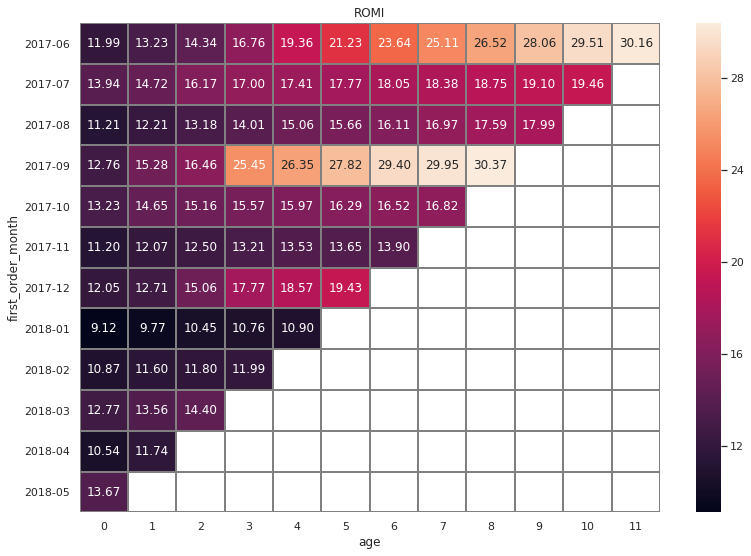

In [17]:
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)

print(output.fillna(''))
print(report_new['romi'].mean())

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(output, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray')

Наиболее высокая окупаемость в июньской, июльской и сентябрьской когортах. Самые низкие показатели окупаемости в январе, скорее всего после праздников и предновогодних трат, покупатели не имеют возможности тратить финансы на развлечения. В среднем затраты окупаются в 2,7 раза.

                                  revenue  costs_x  n_buyers       ltv  \
source_id age first_order_month                                          
1         0   2017-06-01          9557.49  1125.61      2023  4.724414   
              2017-07-01         11557.65  1072.88      1923  6.010218   
              2017-08-01          7228.83   951.81      1370  5.276518   
              2017-09-01         14568.53  1502.01      2581  5.644529   
              2017-10-01         21716.20  2315.75      4340  5.003733   
...                                   ...      ...       ...       ...   
10        9   2017-07-01           282.96   329.82      1923  0.147145   
              2017-08-01           257.53   232.57      1370  0.187978   
          10  2017-06-01          1155.66   314.22      2023  0.571261   
              2017-07-01           299.36   329.82      1923  0.155673   
          11  2017-06-01           519.62   314.22      2023  0.256856   

                                     

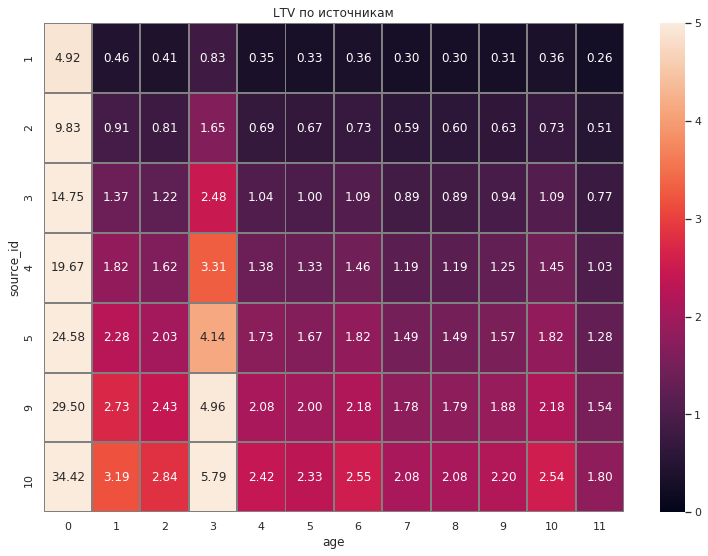

In [33]:
#LTV по источникам
ltv_on_source_id = report_new.groupby(['source_id', 'age', 'first_order_month'])['revenue', 'costs_x', 'n_buyers'].sum()
ltv_on_source_id['ltv'] = ltv_on_source_id['revenue']/ltv_on_source_id['n_buyers']
ltv_on_source_id['cac'] = ltv_on_source_id['costs_x'] / ltv_on_source_id['n_buyers']
ltv_on_source_id['romi'] = ltv_on_source_id['ltv'] / ltv_on_source_id['cac']
print(ltv_on_source_id)

pivot_ltv_source_id = ltv_on_source_id.pivot_table(
    index='source_id', 
    columns='age', 
    values='ltv', 
    aggfunc='mean').cumsum().round(2)

print(pivot_ltv_source_id)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV по источникам')
sns.heatmap(pivot_ltv_source_id, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray',
           vmin=0, vmax=5)

age           0     1     2      3     4     5     6     7     8     9     10  \
source_id                                                                       
1           8.60  0.78  0.71   1.44  0.60  0.58  0.63  0.50  0.51  0.54  0.65   
2          12.79  1.16  1.05   2.14  0.88  0.86  0.93  0.75  0.75  0.80  0.96   
3          14.06  1.28  1.15   2.35  0.97  0.95  1.03  0.82  0.82  0.88  1.05   
4          16.95  1.54  1.38   2.80  1.16  1.13  1.23  0.98  0.98  1.05  1.26   
5          20.40  1.85  1.66   3.37  1.41  1.37  1.49  1.19  1.19  1.27  1.53   
9          52.83  4.77  4.29   8.64  3.66  3.54  3.87  3.11  3.11  3.36  4.05   
10         83.63  7.55  6.80  13.54  5.79  5.59  6.07  4.93  4.93  5.32  6.34   

age          11  
source_id        
1          0.46  
2          0.68  
3          0.74  
4          0.89  
5          1.09  
9          2.91  
10         4.56  
                                  revenue  costs_x  n_buyers       ltv  \
source_id age first_order_month   

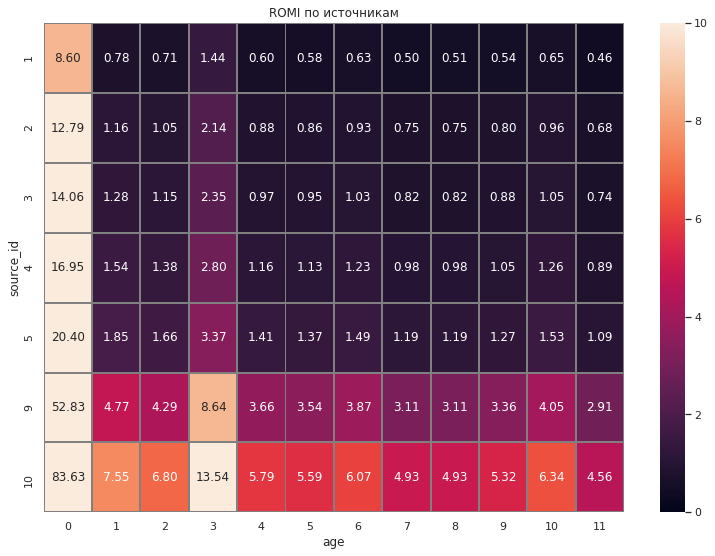

In [19]:
#romi по источникам
romi_on_source_id = ltv_on_source_id.pivot_table(
        index='source_id', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum().round(2)

print(romi_on_source_id)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI по источникам')
sns.heatmap(romi_on_source_id, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray',
            vmin=0, vmax=10)
print(ltv_on_source_id.head())

Наибольшую прибыль принесла третья когорта. Наиболее окупаемые рекламные источники 9 и 10. Дольше всего окупаются источники 1,2,3 и 4

## 5. Общие выводы

1. Количество посетителей и покупателей с платформы desktop и touch различаются. С desktop посещают и покупают чаще примерно в 3 раза, при этом средний чек с платформы touch выше на 25%. Покупка с начала сессии проиходит в среднем через 9 минут с начала сессии. Необходимо проанализировать работу через touch и выяснить причины меньшего количества посещений и покупок с данной платформы, так как покупки с touch приносят больше прибыли (по среднему чеку).

2. Количесто вернувшихся клиентов в среднем (Retention Rate) в первой когорте составляет 6,5 %. Во второй, третьей и последующих когортах Retention Rate убывает быстрее, то есть количество возвращающихся клиентов падает, особенно в зимние месяцы. Таким образом, получается что летние посетители наиболее часто возвращаются на сайт. Retention Rate c платформы touch выше по когортам, чем с платформы desktop, скорее всего это связано с тем, что с платформы touch легче зайти на сайт, так как смартфон "всегда под рукой". Необходимо увеличивать количество возвращающихся клиентов на сайт, в особенности с платформы touch.

3. Несмотря на то, что бизнес по общим расходам убыточен. В среднем затраты окупаются в 2,7 раза. Наибольшая часть прибыли приходится на лето (каникулы школьников и отпуска) и начало осени (сентябрь), а также предновогодний период. 

4. Больше всего окупаются клиенты в июне (перед этим растут рекламные расходы на все источники в апреле), то есть окупаемость происходит за 2 месяца. Рост расходов на рекламные источники №3 и №4 в августе приносит свои плоды уже в сентябре. 

5. Наиболее окупаемые источники №9 и №10, расходы на них приносят больше всего прибыли. Источники №1,2,3 и 4 окупаются дольше всего. Истоник №3 самый дорогой и долго окупаемый, но при этом приносит быстрый рост количества покупателей. Можно рассмотреть оптимизацию расходов на источники №1 и №2 (они долго окупаются и не приносят большого количества клиентов) 

